We start by importing the necessary libraries and functions as following

In [33]:
# Import basic necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import random

# General functions for ML Workflows
from sklearn.model_selection import train_test_split # Splitting data
from sklearn.metrics import mean_squared_error, r2_score # Scoring functions

# Impute Estimated Average Stage Time
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor # RandomForest Regressor for Multiple Response Features

# Uncertainty Goodness
from UTuning import scorer, plots  # Cruz, Pyrcz (2021) version of calculating Uncertainty Goodness
from ozbayrak_goodness import goodness # Ozbayrak, Foster, Pyrcz (2025) version of calculating Uncertainty Goodness
from scipy.stats import norm # Also necessary for Ozbayrak, Foster, Pyrcz (2025) version subroutine

%matplotlib inline

## Pre-Process

We import data, and then we delete 3 entries where actual average stage time is less than or equal to zero (setting them to NaN). Then, we drop the column **Fleet Type**. We do this, because when we review data carefully, we notice that all Frac Fleets are performing only one type of Fleet Type. Hence, information-wise, the knowledge that a ML model can obtain from Fleet Type must be already contained within the Frac Fleet feature.

In [2]:
# Import data
df = pd.read_csv('HackathonData2025.csv')

# Set AAST <=0 to NaN
df.loc[df['Actual Average Stage Time'] <= 0, 'Actual Average Stage Time'] = pd.NA

# Drop the 'Fleet Type' column
df = df.drop(columns=['Fleet Type'])

## Feature Engineering

### Impute Temperature

When the data is reviewed, it could be noted that the *consecutive entries* with *same padding* name and *increasing well number* will always have the same temperature. Based on this, it is possible to impute all NaN temperatures except two wells. These two wells are the only wells of the same padding in the consecutive entries. However, when these are visually inspected, it is obvious that they have the same temperature with the adjacent entries as well. So, we will set those two wells by hand, and impute the rest according to the mentioned rule.

In [3]:
#  Extract "PadName" and numeric well number "WellNum"
#  Example well name: "Anderson 5H" -> PadName="Anderson", WellNum=5
#  We'll use two steps: first split into two columns, then remove the "H".
split_cols = df["Well Name"].str.rsplit(" ", n=1, expand=True)
df["PadName"] = split_cols[0]           # e.g. "Anderson"
df["WellSuffix"] = split_cols[1]        # e.g. "5H"

df["WellNum"] = (df["WellSuffix"]
                 .str.replace("H", "", regex=False)  # remove the letter H
                 .astype(int))                        # convert to integer

#  Define a new column 'PadGroup' that increments whenever
#  - Pad Name changes, OR
#  - Well number is NOT strictly larger than previous row's well number
#    (meaning if it repeats or goes backward, new group!)
df["PadGroup"] = (
    (df["PadName"] != df["PadName"].shift())  # pad changed
    | (df["WellNum"] <= df["WellNum"].shift()) # not strictly increasing
).cumsum()

df = df.drop(columns="WellSuffix")

# Now group by (PadName, PadGroup)
groups = df.groupby(["PadName", "PadGroup"])

# Impute all NaN temperatures by the group temperature
# All groups are visually inspected to have the same temperature.
# The only caveat occurs when the entire group has NaN for the temperature.
# We will separate those cases, and we will see that, luckily, those belong to the
# same temperature group with the adjacent entries.

all_nan_groups = []  # We'll store (pad, grp_id) for the groups with all NaN

for (pad, grp_id), sub_df in groups:
    # Check if it's fully NaN
    if sub_df["Ambient Temperature"].isna().all():
        # We'll fix this later by hand
        all_nan_groups.append((pad, grp_id))
    else:
        # Compute median ignoring NaN
        median_val = sub_df["Ambient Temperature"].median(skipna=True)
        
        # Fill the missing rows of this group with the median
        # Use .loc with the sub_df index so we only update those rows
        df.loc[sub_df.index, "Ambient Temperature"] = (
            df.loc[sub_df.index, "Ambient Temperature"]
              .fillna(median_val)
        )

# There are only 2 fully NaN groups, and
# each has only 1 well. We inspect them locally and notice
# that they belong to the same temperature group with the
# adjacent entries as we mentioned above. The obtained values are:
# ('Rich', 52):     49.7
# ('Flagler', 131): 70.5

manual_fixes = {
    ("Rich", 52): 49.7,
    ("Flagler", 131): 70.5
}

for (pad, grp_id), value in manual_fixes.items():
    # Identify those rows
    mask = (df["PadName"] == pad) & (df["PadGroup"] == grp_id)
    
    # Assign the chosen value
    df.loc[mask, "Ambient Temperature"] = value

### Impute EstAvgStT

We have initially built a model by simply discarding all the rows that contain NaN values, after imputing temperatures, and the resulting model yielded great accuracy ($R^{2}>0.95$). However, this model used Estimated Average Stage Time, and we knew that ~10% of Estimated Average Stage Time entries in both the training and the testing datasets were missing, so we needed a strategy to impute them with the features that exist in the both datasets. Due to time constraints, we aimed to create a fast but "good enough" model that will retain the good $R^{2}$ values.

In [4]:
# Define target and features
target_col = "Estimated Average Stage Time"
feature_cols = ["Frac Fleet", "Target Formation", "Ambient Temperature", "Fuel Type"]

# Separate rows with and without NaN in the target
df_train_test = df.dropna(subset=[target_col])  # Rows with valid target
df_impute = df[df[target_col].isna()]  # Rows where target is NaN

# Separate features and target for training/testing
X = df_train_test[feature_cols]
y = df_train_test[target_col]

# Features for imputation
X_impute = df_impute[feature_cols]

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numerical_cols = X.select_dtypes(include=["number"]).columns.tolist()

# Preprocessing steps
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

# Model
model = RandomForestRegressor(random_state=23, n_estimators=100)

# Pipeline
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", model)
])

# Splitting data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=23
)

# Fit a model using the pipeline
pipeline.fit(X_train, y_train)

# Predict on test set
y_pred = pipeline.predict(X_test)

# Evaluate model scores
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Display model scores
print("Model Performance on Test Data:")
print(f"  RMSE: {rmse:.3f}")
print(f"  R^2 : {r2:.3f}")


Model Performance on Test Data:
  RMSE: 9.649
  R^2 : 0.804


An $R^{2}$ of 0.804 is sufficient for imputing this feature in the testing data. Furthermore, this $R^{2}$ is coming from the model that only uses the train split of the training data. For imputing the values, we then trained the same model with all available training data, and we impute the missing values with it.

In [1]:
# Fit entire available data
pipeline.fit(X, y)

# Impute missing values for training data (processing of the testing data will be later)
imputed_values = pipeline.predict(X_impute)
df.loc[df[target_col].isna(), target_col] = imputed_values

NameError: name 'pipeline' is not defined

### Engineer "Estimated Total Time"

We have observed the following:

- The power consumption is directly related to total pumped slurry volume by our domain knowledge.
- A model that has less features is always preferred, as it is going to be more robust and more interpretable. This is why, combining features into one feature while retaining their information is a great strategy.

Given these two, we have derived a feature named **Estimated Total Time**, which is obtained by multiplying Estimated Average Stage Time with Number of Stages. This gives a good metric of total time spend for the operation, which is a very good indicator of total pumped volume, hence the total power consumption. Also, by doing this, we have reduced 2 features that we were most certainly going to use to one. In the following parts of this workflow, we extensively test the robustness of the model due to this feature as well.

In [5]:
# Create the new feature
df['Estimated Total Time'] = df['Estimated Average Stage Time'] * df['# Stages']

## Model Building

### Feature Ranking

Throughout this workflow, we will employ **MultiOutputRegressor**, which is a built-in algorithm for applying **Random Forest Regression** (Breiman, 2001) for multiple response features. We initially built a model with this pipeline, which yielded a great $R^{2}$. Then, we tried a vast collection of different combination of numerical and categorical features with the default hyperparameters. Here, for demonstration purposes, we only keep 5 of those, and we also test the robustness of the model that uses our engineered feature, Estimated Total Time. 

The way we tested these models built with different set of features is as follows: For each set, we have done a train-validate split, trained and validated the model for 100 different random seeds. We did this, because since the accuracies are very high, the randomness aspect was creating a difference in the accuracies independent of the model robustness, and to mitigate it, we used *law of large numbers* and run the same model for 100 different scenarios to observe the mean the accuracy converges to, and the distribution of accuracy. 

Our tests show that the model that uses our engineered feature and the least amount of other features was the most robust, with an extremely high $R^{2}$ around 0.97-0.99. After this, we didn't even tune for the hyperparameters, as this accuracy is good enough.


=== Feature Set 1: {'numerical': ['# Clusters ', 'Estimated Total Time'], 'categorical': ['Fuel Type', 'Frac Fleet', 'Target Formation']} ===

=== Feature Set 2: {'numerical': ['# Clusters ', 'Ambient Temperature', 'Estimated Total Time'], 'categorical': ['Fuel Type', 'Frac Fleet']} ===

=== Feature Set 3: {'numerical': ['Ambient Temperature', 'Estimated Total Time'], 'categorical': ['Fuel Type', 'Target Formation']} ===

=== Feature Set 4: {'numerical': ['Ambient Temperature', 'Actual Average Stage Time'], 'categorical': ['Fuel Type', 'Frac Fleet', 'Target Formation']} ===

=== Feature Set 5: {'numerical': ['Ambient Temperature', 'Estimated Total Time'], 'categorical': ['Fuel Type', 'Frac Fleet', 'Target Formation']} ===
    Feature Set    Fuel        R2
0             1     CNG  0.944623
1             1  Diesel  0.964711
2             1    Grid  0.984278
3             2     CNG  0.963746
4             2  Diesel  0.970481
5             2    Grid  0.983226
6             3     CNG  0.95

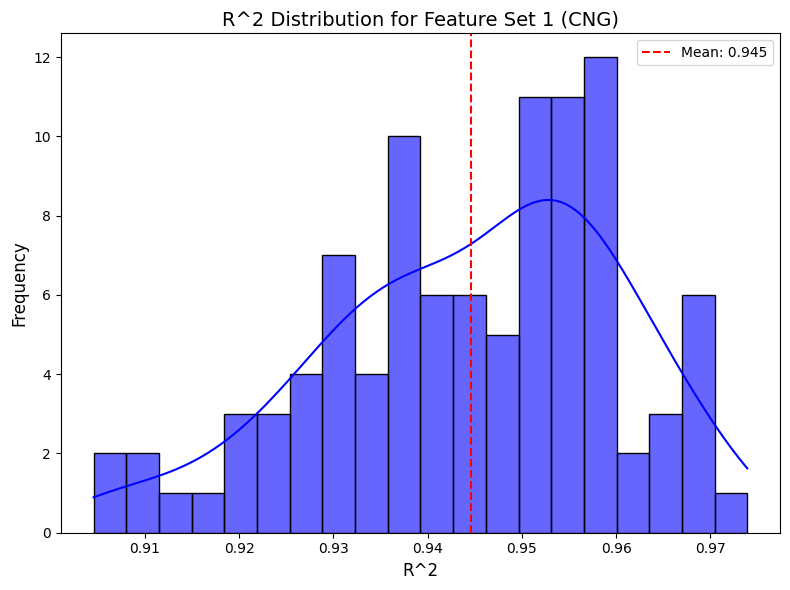

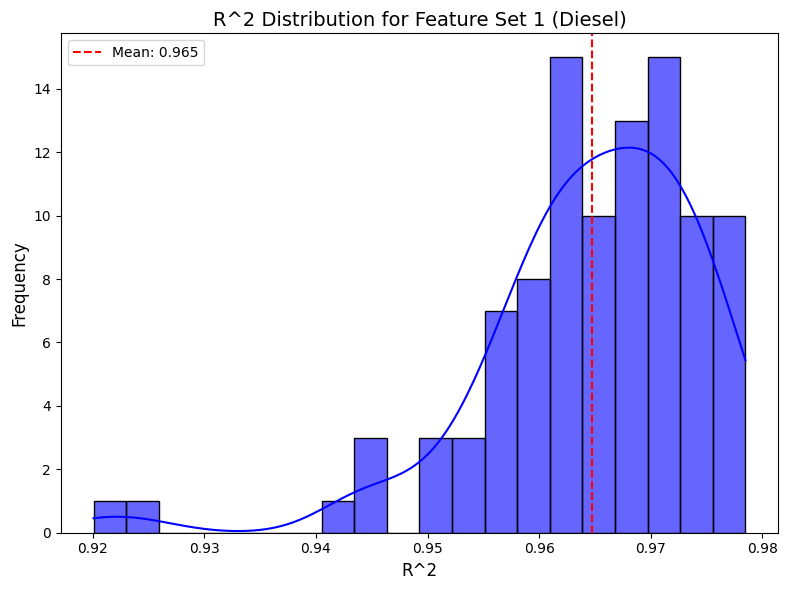

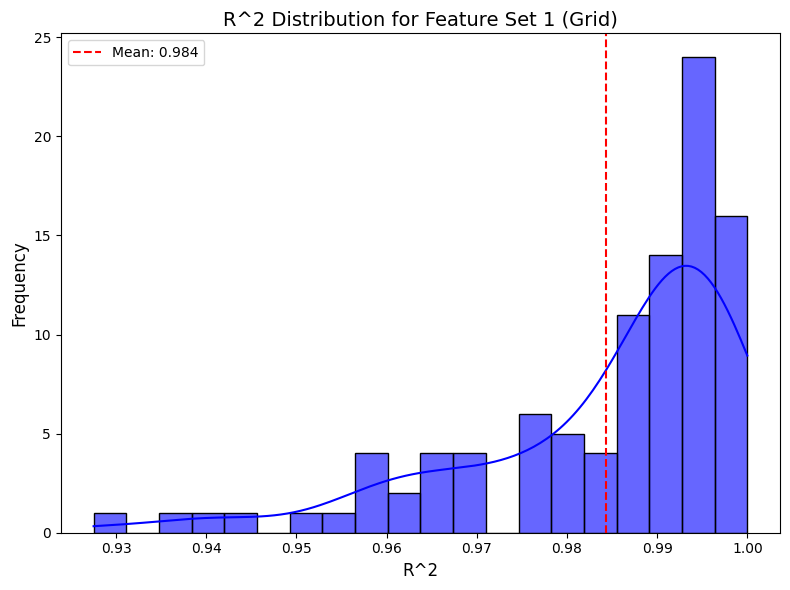

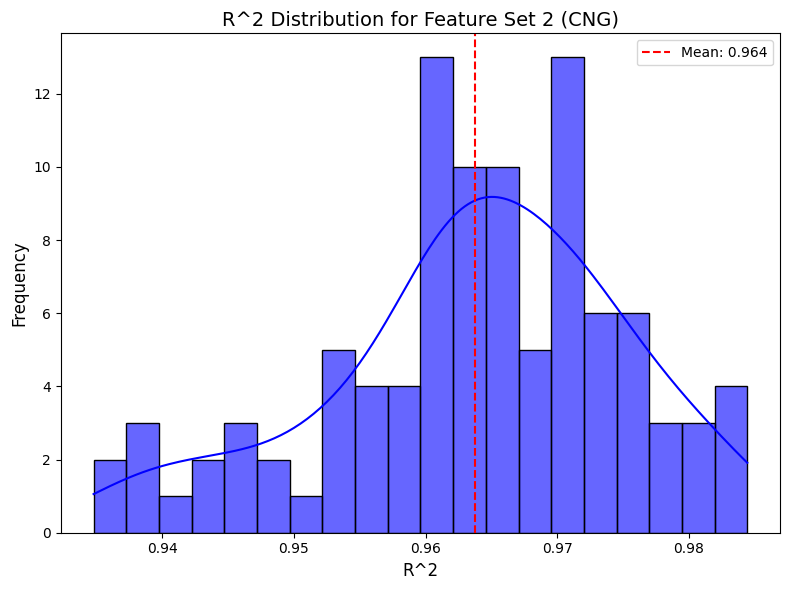

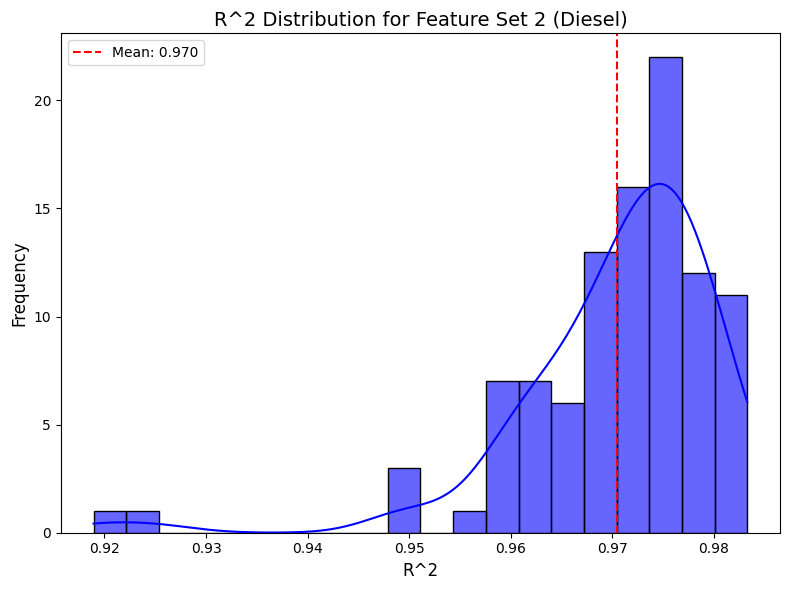

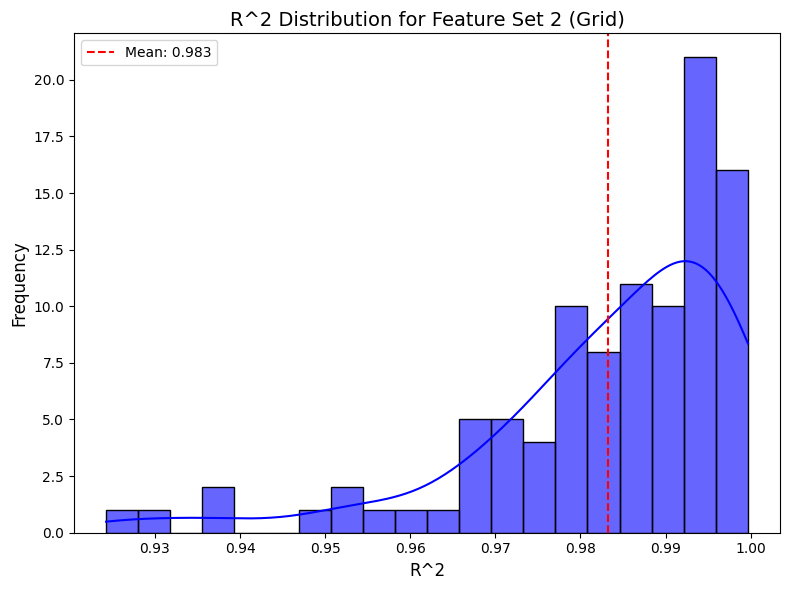

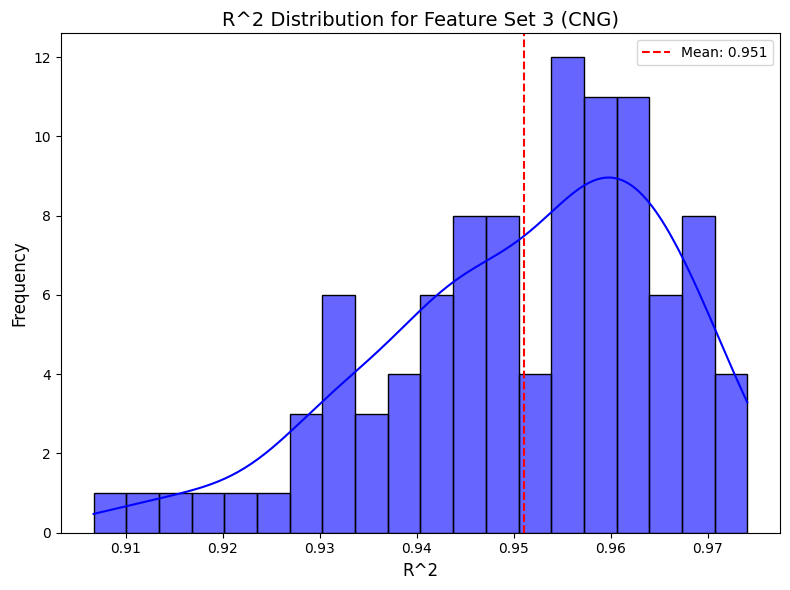

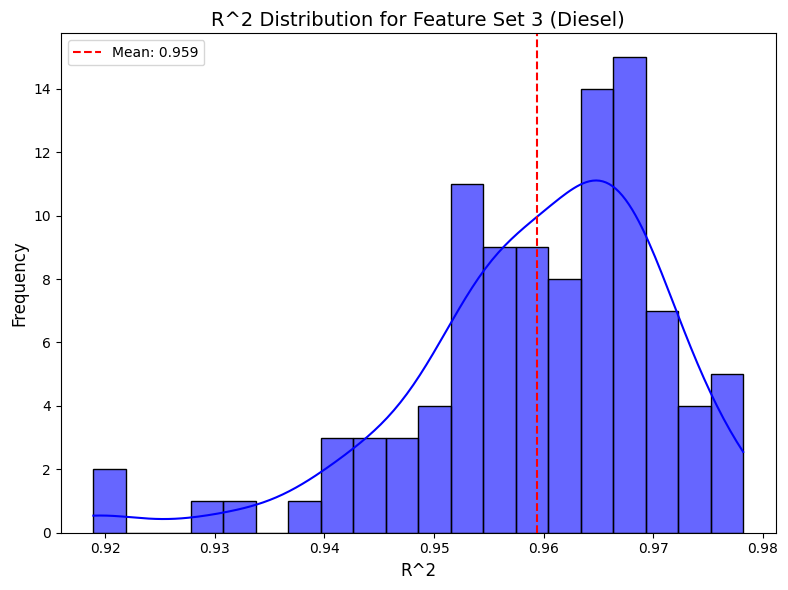

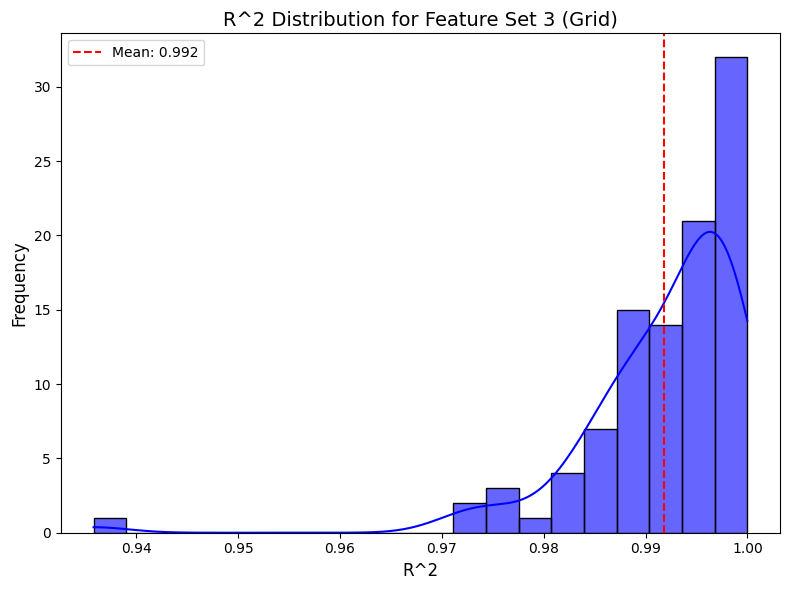

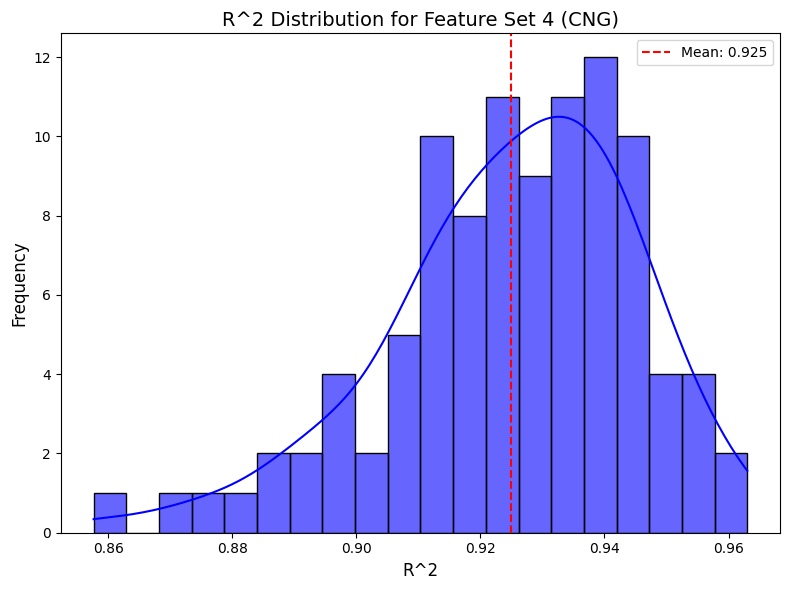

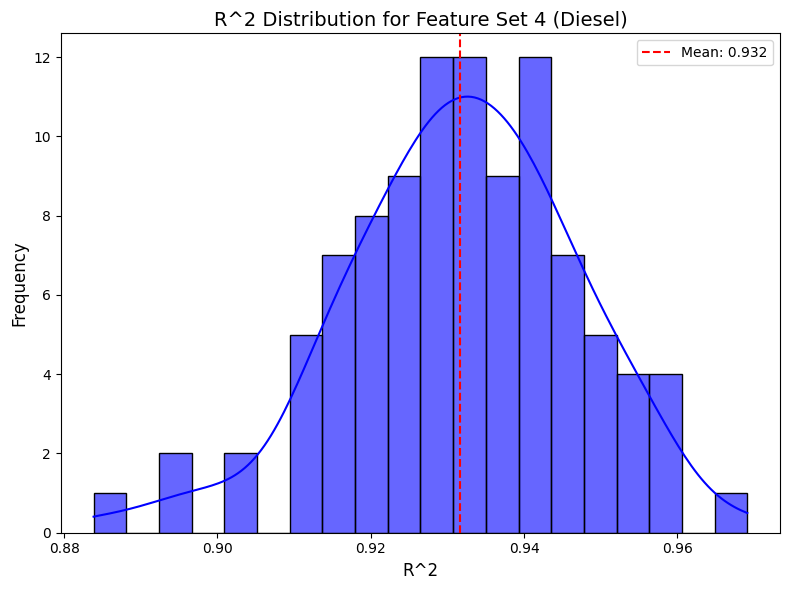

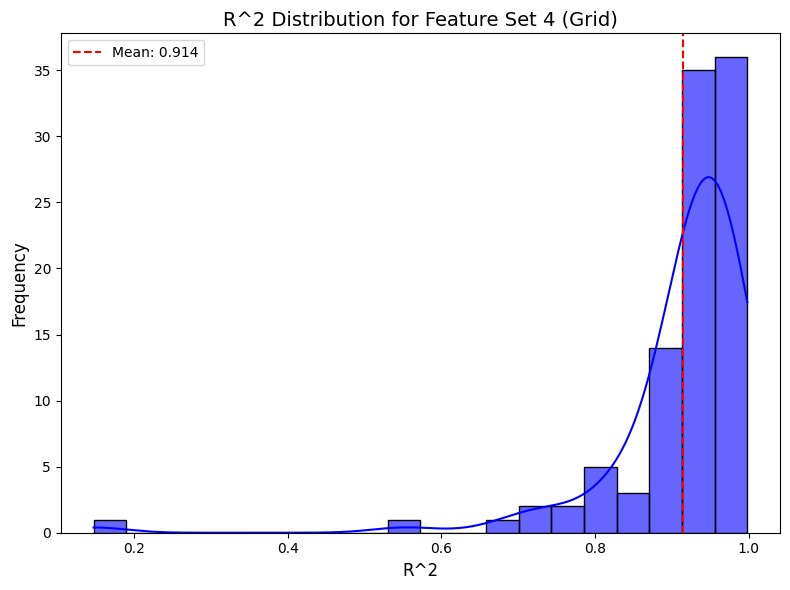

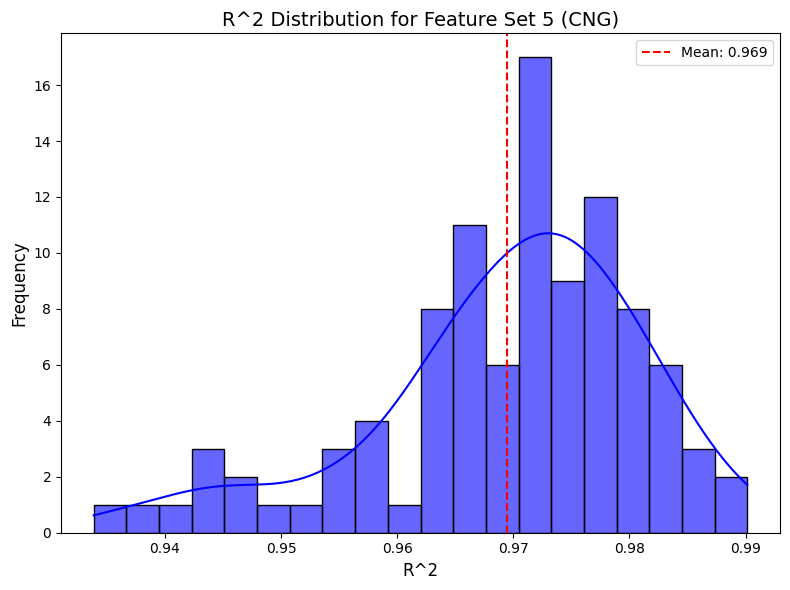

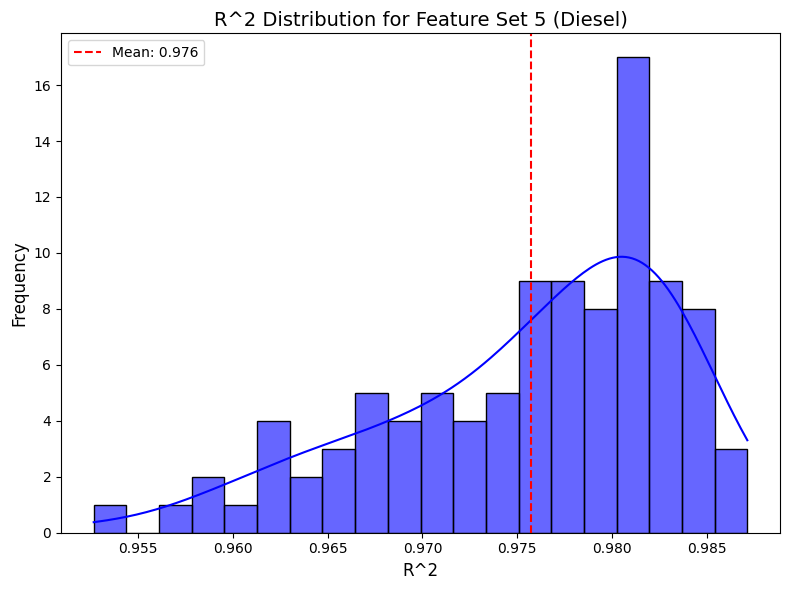

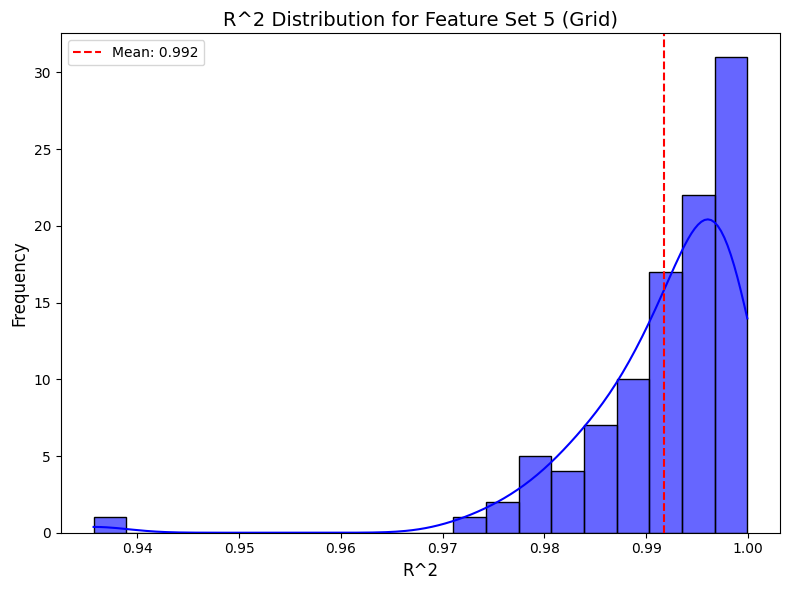

In [6]:
# Define different feature sets to iterate over
feature_sets = [
    {
        "numerical": ["# Clusters ", "Estimated Total Time"],
        "categorical": ["Fuel Type", "Frac Fleet", "Target Formation"]
    },
    {
        "numerical": ["# Clusters ", "Ambient Temperature", "Estimated Total Time"],
        "categorical": ["Fuel Type", "Frac Fleet"]
    },
    {
        "numerical": ["Ambient Temperature", "Estimated Total Time"],
        "categorical": ["Fuel Type", "Target Formation"]
    },
    {
        "numerical": ["Ambient Temperature", "Actual Average Stage Time"],
        "categorical": ["Fuel Type", "Frac Fleet", "Target Formation"]
    },
    {
        "numerical": ["Ambient Temperature", "Estimated Total Time"],
        "categorical": ["Fuel Type", "Frac Fleet", "Target Formation"]
    },
]

# Store results
results = []

# Loop over feature sets
for i, feature_set in enumerate(feature_sets, start=1):
    print(f"\n=== Feature Set {i}: {feature_set} ===")

    # Encode categorical variables
    df_encoded = pd.get_dummies(df, columns=feature_set["categorical"], drop_first=False)

    # Define feature columns
    feature_cols = feature_set["numerical"]
    for col in df_encoded.columns:
        for cat in feature_set["categorical"]:
            if col.startswith(f"{cat}_"):
                feature_cols.append(col)

    # Define target columns
    Y = df_encoded[["Grid", "Diesel", "CNG"]]

    # Filter rows with no missing values in features and targets
    data = pd.concat([df_encoded[feature_cols], Y], axis=1).dropna()
    X = data[feature_cols]
    Y = data[["Grid", "Diesel", "CNG"]]

    # Loop over seeds
    for seed in range(1, 101):
        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(
            X, Y, test_size=0.2, random_state=seed
        )

        # Train multi-output random forest
        base_rf = RandomForestRegressor(n_estimators=100, random_state=seed)
        multi_rf = MultiOutputRegressor(base_rf)
        multi_rf.fit(X_train, y_train)

        # Predict
        y_pred = multi_rf.predict(X_test)
        y_pred = pd.DataFrame(y_pred, columns=["Grid_pred", "Diesel_pred", "CNG_pred"], index=y_test.index)

        # Calculate metrics
        for fuel_col in ["Grid", "Diesel", "CNG"]:
            true_vals = y_test[fuel_col]
            pred_vals = y_pred[f"{fuel_col}_pred"]
            r2 = r2_score(true_vals, pred_vals)

            # Append results
            results.append({
                "Feature Set": i,
                "Seed": seed,
                "Fuel": fuel_col,
                "R2": r2
            })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Calculate mean R^2 for each feature set and fuel type
mean_r2_by_group = results_df.groupby(['Feature Set', 'Fuel'])['R2'].mean().reset_index()
print(mean_r2_by_group)

# Group by feature sets and fuel
combinations = results_df.groupby(["Feature Set", "Fuel"])

# Loop through combinations and create individual plots
for (feature_set, fuel), group in combinations:
    mean_r2 = group["R2"].mean()

    # Create a new figure for each combination
    plt.figure(figsize=(8, 6))

    # Plot histogram
    sns.histplot(group["R2"], bins=20, kde=True, color='blue', alpha=0.6)

    # Add a vertical line for the mean
    plt.axvline(mean_r2, color='red', linestyle='dashed', linewidth=1.5, label=f"Mean: {mean_r2:.3f}")

    # Add title, labels, and legend
    plt.title(f"R^2 Distribution for Feature Set {feature_set} ({fuel})", fontsize=14)
    plt.xlabel("R^2", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend(fontsize=10)

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

### Training & Validation

Now, essentially the training of the model is over, as the "last" trained model is the one we want to retain, and Jupyter will keep that one. However, this is not very elegant, and that is why, we will train a single model and validate it in a dedicated cell for cleanliness. The process takes less than 5 seconds, so it is adequate. 

In [16]:
# Use the obtained feature set from Feature Ranking step
feature_set = {
        "numerical": ["Ambient Temperature", "Estimated Total Time"],
        "categorical": ["Fuel Type", "Frac Fleet", "Target Formation"]
    }

# Store results
results = []

# Encode categorical variables
df_encoded = pd.get_dummies(df, columns=feature_set["categorical"], drop_first=False)

# Define feature columns
feature_cols = feature_set["numerical"]
for col in df_encoded.columns:
    for cat in feature_set["categorical"]:
        if col.startswith(f"{cat}_"):
            feature_cols.append(col)

# Define target columns
Y = df_encoded[["Grid", "Diesel", "CNG"]]

# Filter rows with no missing values in features and targets
data = pd.concat([df_encoded[feature_cols], Y], axis=1).dropna()
X = data[feature_cols]
Y = data[["Grid", "Diesel", "CNG"]]


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=23
)

# Train multi-output random forest
base_rf = RandomForestRegressor(n_estimators=100, random_state=23)
multi_rf = MultiOutputRegressor(base_rf)
multi_rf.fit(X_train, y_train)

# Predict
y_pred = multi_rf.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=["Grid_pred", "Diesel_pred", "CNG_pred"], index=y_test.index)

After the algorithmic part of training & validation is completed, we visualize the obtained results for inspection.


=== Fuel Type = Grid, #TestRows=3 ===


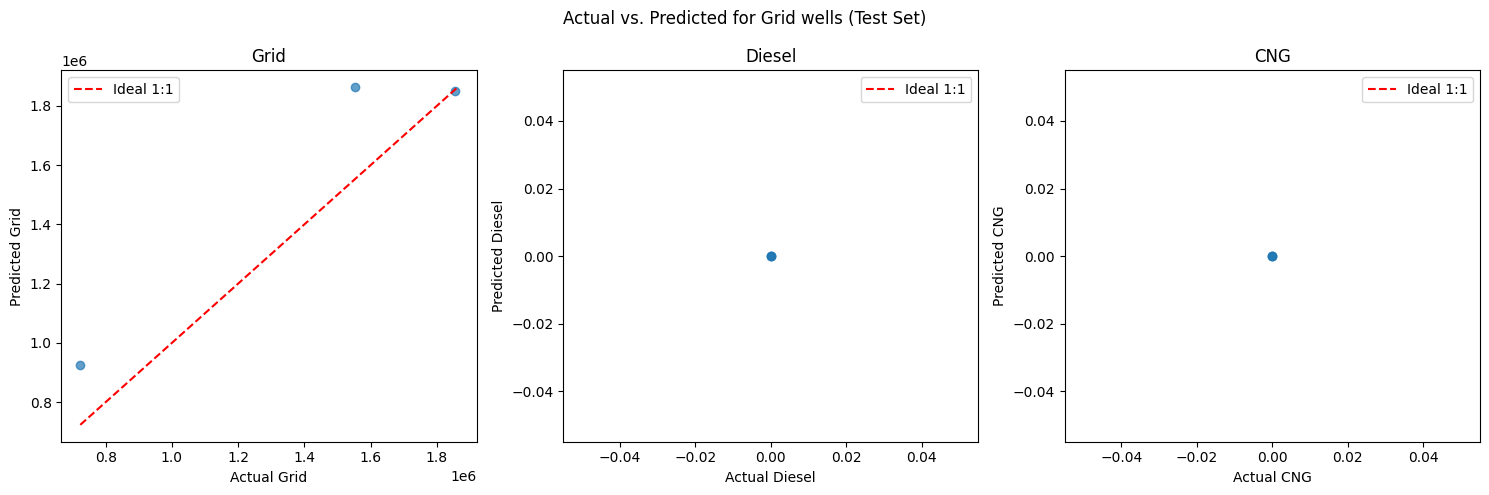


=== Fuel Type = Diesel, #TestRows=87 ===


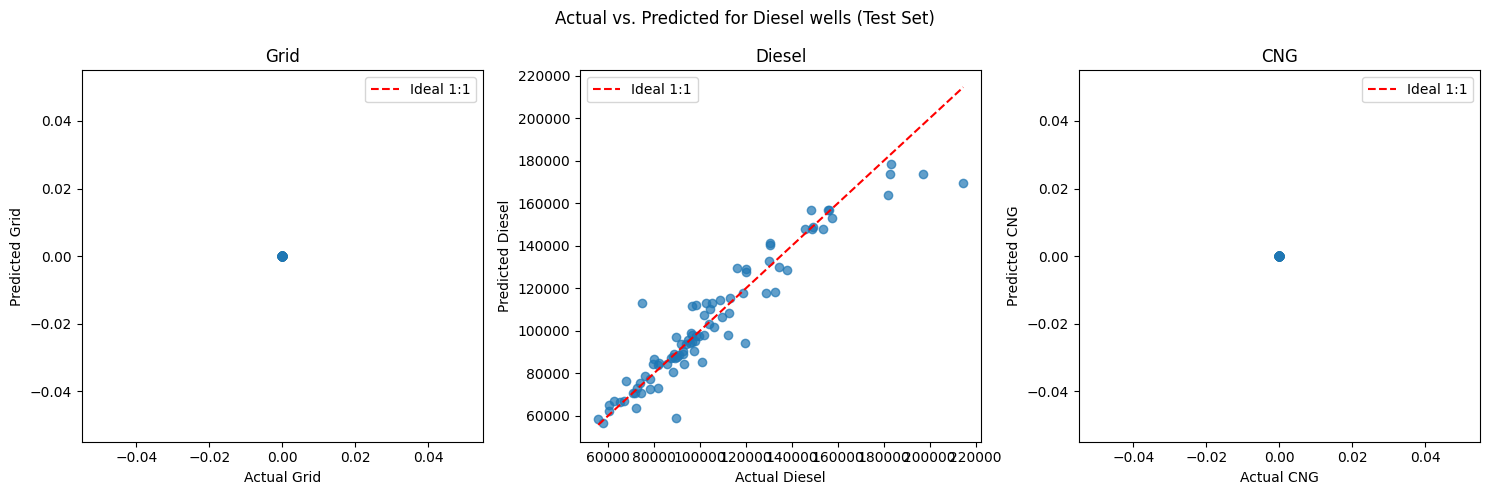


=== Fuel Type = Turbine, #TestRows=66 ===


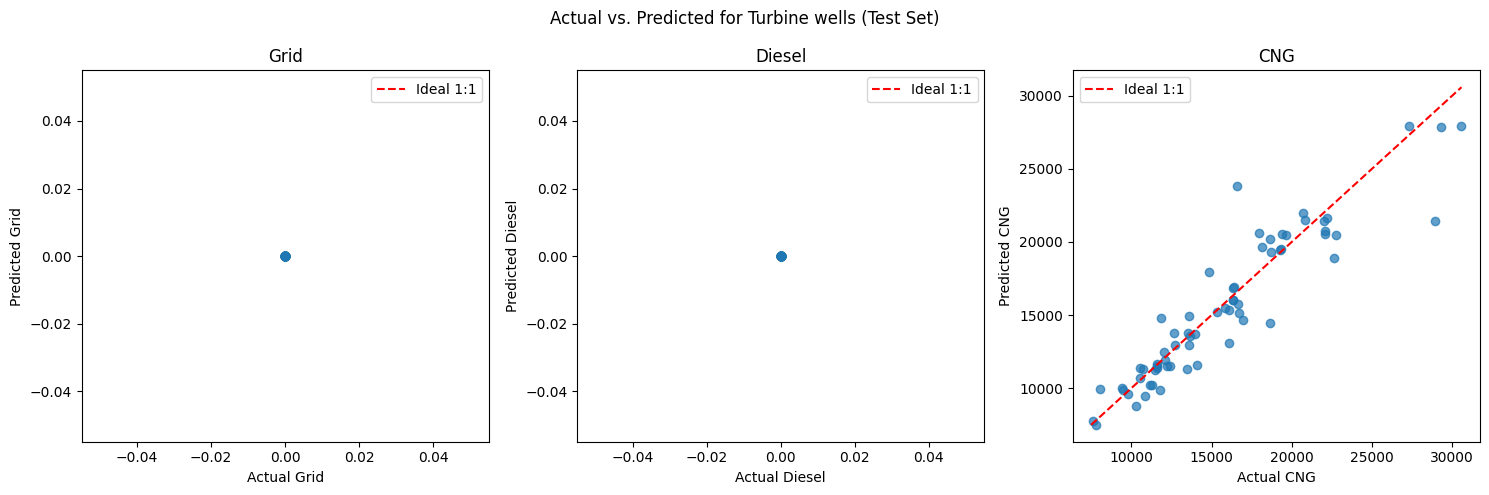


=== Fuel Type = DGB, #TestRows=61 ===


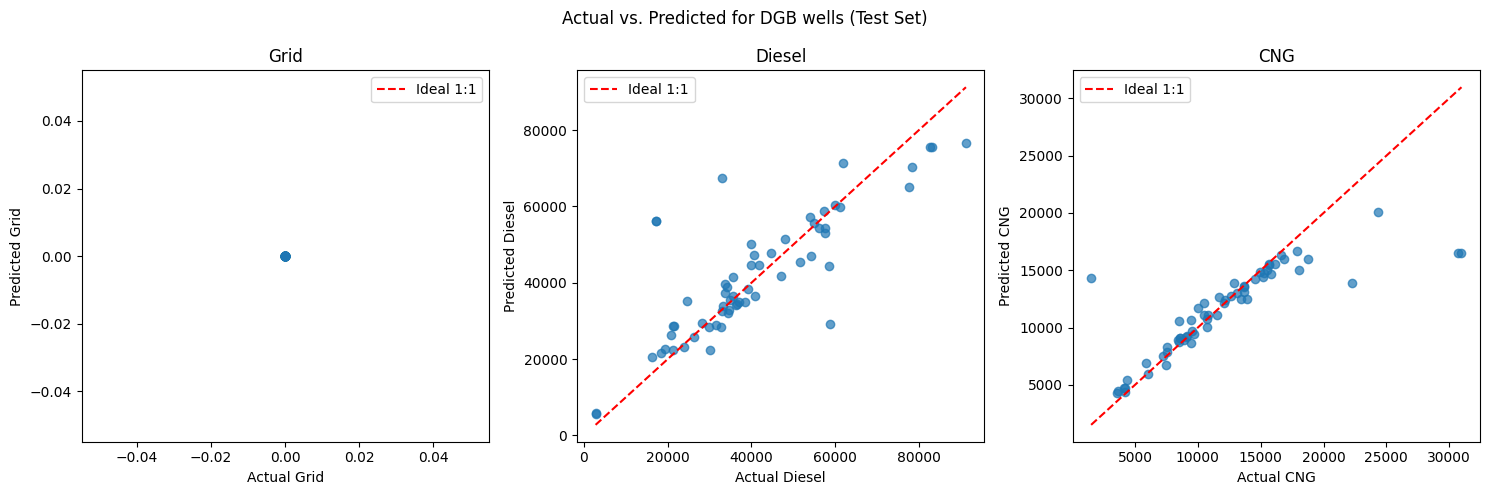


FUEL = Grid:
  RMSE = 25119.557
  R^2  = 0.978

FUEL = Diesel:
  RMSE = 8551.317
  R^2  = 0.971

FUEL = CNG:
  RMSE = 2100.641
  R^2  = 0.934


In [18]:
# Combine test data + predictions
test_results = pd.concat([y_test, y_pred], axis=1)

# We need the real 'Fuel Type' (NOT the one-hot) for each row.
# Make sure the original df has an index that aligns with X_test / y_test.
# For simplicity, assume the original df has the same index before encoding.
# So we can do:
test_results["Fuel Type"] = df.loc[test_results.index, "Fuel Type"]

# Now we can group the test set by the actual Fuel Type
fuel_types = ["Grid","Diesel","Turbine","DGB"]
for ft in fuel_types:
    subset = test_results[test_results["Fuel Type"] == ft]
    if subset.empty:
        print(f"\nNo test samples for Fuel Type={ft}. Skipping plot.")
        continue
    
    print(f"\n=== Fuel Type = {ft}, #TestRows={len(subset)} ===")

    # We'll create a figure with 3 subplots: Grid, Diesel, CNG
    fig, axes = plt.subplots(1, 3, figsize=(15,5), sharey=False)
    fig.suptitle(f"Actual vs. Predicted for {ft} wells (Test Set)")

    # Helper function to scatter plot prediction vs truth
    def scatter_true_pred(ax, df_sub, fuel_name):
        true_col = f"{fuel_name}"
        pred_col = f"{fuel_name}_pred"
        ax.scatter(df_sub[true_col], df_sub[pred_col], alpha=0.7)
        # 1:1 line
        mn = min(df_sub[true_col].min(), df_sub[pred_col].min())
        mx = max(df_sub[true_col].max(), df_sub[pred_col].max())
        ax.plot([mn, mx], [mn, mx], color='red', linestyle='--', label='Ideal 1:1')
        ax.set_xlabel(f"Actual {fuel_name}")
        ax.set_ylabel(f"Predicted {fuel_name}")
        ax.legend()
        ax.set_title(fuel_name)

    # Plot each fuel
    scatter_true_pred(axes[0], subset, "Grid")
    scatter_true_pred(axes[1], subset, "Diesel")
    scatter_true_pred(axes[2], subset, "CNG")

    plt.tight_layout()
    plt.show()

# Calculate metrics for each fuel column
for i, fuel_col in enumerate(["Grid","Diesel","CNG"]):
    true_vals = y_test[fuel_col]
    pred_vals = y_pred[f"{fuel_col}_pred"]
    mse = mean_squared_error(true_vals, pred_vals)
    rmse = np.sqrt(mse)
    r2 = r2_score(true_vals, pred_vals)
    print(f"\nFUEL = {fuel_col}:")
    print(f"  RMSE = {rmse:.3f}")
    print(f"  R^2  = {r2:.3f}")

#### Uncertainty Subroutine

Now, since we finished training our model, before using it for the prediction and uncertainty model building, we analyze and fine-tune it for uncertainty quantification. 

We will again use the training & validation splits, but this time for uncertainty model building instead of prediction. Since we have the real values for validation set, just like the prediction training, we can plot and calculate uncertainty goodness. Since there are different ways to calculate uncertainty goodness (the formula is the same and it is coming from Deutsch' Uncertainty Goodness, more information can be obtained from the manuscript (Deutsch, 1997), but there are different implementations, like Energy AI Hackathon 2024 version etc.), we will use two ways of doing it:

- UTuning package (Maldonado-Cruz and Pyrcz 2021): This is the most robust implementation available for Deutsch' Uncertainty Goodness
- $p-\xi(p)$ plot (Ozbayrak, Foster and Pyrcz, 2025): This is essentially the same plot, but instead of plotting $x=y$ and the uncertainty curve, the difference is plotted for easier numerical integration and visualization. When the curve is below the $x=y$ line, the obtained value is negative and when it is above the line, the obtained value is positive

We start by creating & storing the uncertainty distribution:

In [21]:
# Store estimators without aggregation
grid_estimators = np.array([est.predict(X_test) for est in multi_rf.estimators_[0].estimators_]).T
diesel_estimators = np.array([est.predict(X_test) for est in multi_rf.estimators_[1].estimators_]).T
cng_estimators = np.array([est.predict(X_test) for est in multi_rf.estimators_[2].estimators_]).T

# Combine realizations into a DataFrame for easier analysis
estimators_df = pd.DataFrame()

# Add realizations for each target
for i in range(100):
    estimators_df[f"Grid_R{i+1}"] = grid_estimators[:, i]
    estimators_df[f"Diesel_R{i+1}"] = diesel_estimators[:, i]
    estimators_df[f"CNG_R{i+1}"] = cng_estimators[:, i]

# Add the corresponding index from X_test for traceability
estimators_df.index = X_test.index

# Create a DataFrame to store results
uncertainty_results = pd.DataFrame(index=estimators_df.index)

# Add Well Names as the first column
uncertainty_results["Well Name"] = df.loc[estimators_df.index, "Well Name"]

# Add the real fuel value (y_test) as the second column
fuel_values = []
for idx in y_test.index:
    fuel_type = df.loc[idx, "Fuel Type"]
    if fuel_type in ["DGB_CNG", "Turbine", "CNG"]:
        fuel_values.append(y_test.loc[idx, "CNG"])
    elif fuel_type in ["DGB_Diesel", "Diesel"]:
        fuel_values.append(y_test.loc[idx, "Diesel"])
    elif fuel_type == "Grid":
        fuel_values.append(y_test.loc[idx, "Grid"])
    elif fuel_type == "DGB":
        # Randomly choose between CNG and Diesel
        chosen_fuel = np.random.choice(["CNG", "Diesel"])
        fuel_values.append(y_test.loc[idx, chosen_fuel])
    else:
        raise ValueError(f"Unexpected fuel type: {fuel_type}")

uncertainty_results["Fuel Value"] = fuel_values

# Add the 100 estimators based on fuel type
for idx in estimators_df.index:
    fuel_type = df.loc[idx, "Fuel Type"]
    if fuel_type in ["DGB_CNG", "Turbine", "CNG"]:
        selected_columns = [f"CNG_R{i+1}" for i in range(100)]
    elif fuel_type in ["DGB_Diesel", "Diesel"]:
        selected_columns = [f"Diesel_R{i+1}" for i in range(100)]
    elif fuel_type == "Grid":
        selected_columns = [f"Grid_R{i+1}" for i in range(100)]
    elif fuel_type == "DGB":
        chosen_fuel = np.random.choice(["CNG", "Diesel"])
        selected_columns = [f"{chosen_fuel}_R{i+1}" for i in range(100)]
    else:
        raise ValueError(f"Unexpected fuel type: {fuel_type}")

    uncertainty_results.loc[idx, [f"R{i+1}" for i in range(100)]] = estimators_df.loc[idx, selected_columns].values


/home/multifrac/defaults/.venv/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/multifrac/defaults/.venv/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/multifrac/defaults/.venv/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/multifrac/defaults/.venv/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/multifrac/defaults/.venv/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/multifrac/defaults/.venv/lib/python3.8/site-

Then, we proceed with UTuning workflow

  Accuracy = 0.03
  Precision = 1.00
  Goodness = 0.96


<Figure size 800x600 with 0 Axes>

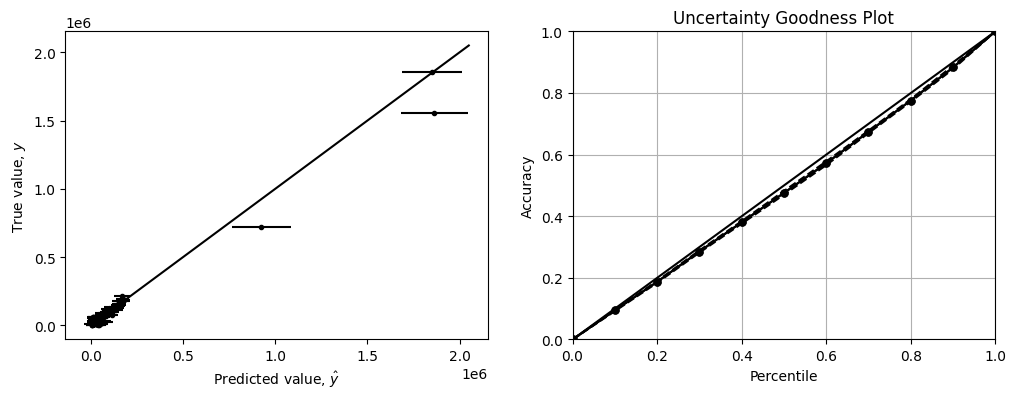

In [29]:
# Collect the true values for the validation set
y_true = uncertainty_results['Fuel Value'].values  # Shape: (num_samples,)
R_columns = [f'R{i}' for i in range(1, 101)]
ens_preds = uncertainty_results[R_columns].values  # Shape: (num_samples, 100)

# Compute ensemble statistics
pred_mean = ens_preds.mean(axis=1)  # Mean prediction
knowledge_u = np.std(ens_preds, axis=1)  # Knowledge uncertainty (epistemic)

# Estimate data uncertainty (aleatoric) using residuals
residuals = y_true - pred_mean
data_u = np.std(residuals)  # Alternatively, use another appropriate method
Sigma = knowledge_u + data_u  # Total uncertainty

# Initialize the scorer with predictions, true values, and uncertainties
scorer_obj = scorer.scorer(pred_mean, y_true, Sigma)

# Compute the Indicator Function
IF_array = scorer_obj.IndicatorFunction()

# Compute Average Indicator Function
avgIF = np.mean(IF_array, axis=0)

# Define percentiles for plotting (e.g., 0%, 10%, ..., 100%)
n_quantiles = 11
perc = np.linspace(0.0, 1.00, n_quantiles)

# Plot Error Accuracy
plt.figure(figsize=(8, 6))
plots.error_accuracy_plot(perc, IF_array, pred_mean, y_true, Sigma)

# Enhance plot aesthetics
plt.title(f'Uncertainty Goodness Plot')
plt.xlabel('Percentile')
plt.ylabel('Accuracy')
plt.grid(True)

# Print Metrics
accuracy = scorer_obj.Accuracy()
precision = scorer_obj.Precision()
goodness = scorer_obj.Goodness()

print(f"  Accuracy = {accuracy:.2f}")
print(f"  Precision = {precision:.2f}")
print(f"  Goodness = {goodness:.2f}")

The plot coming from UTuning indicates a very good uncertainty modeling. The obtained curve is only *slightly below* $x=y$ line.

Next, $p-\xi(p)$ plot indicates also the same thing (negative area with a very small $y$ after $x\approx 0.3$)

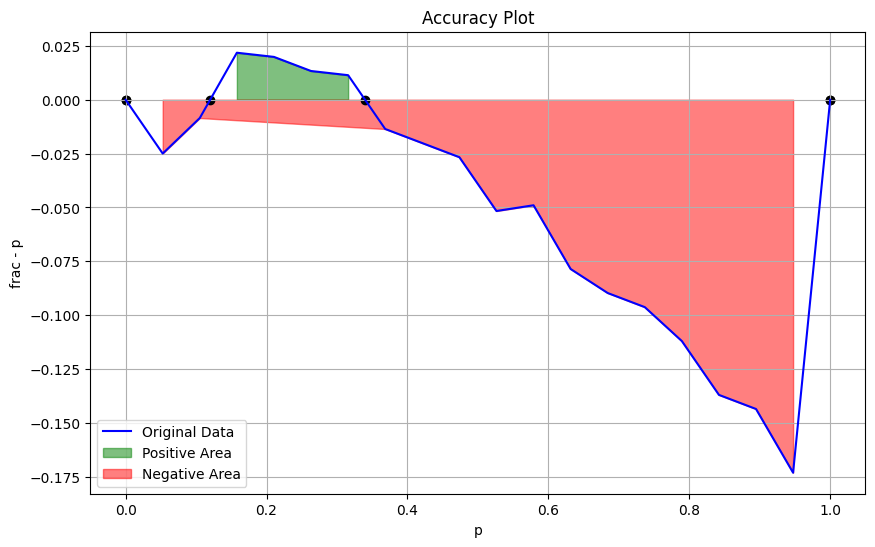

Integral of the positive part: 0.0026232814634208654
Integral of the negative part: 0.04883175681138327
=== RESULTS ===
Number of wells in CSV: 217
p_intervals = [0.         0.05263158 0.10526316 0.15789474 0.21052632 0.26315789
 0.31578947 0.36842105 0.42105263 0.47368421 0.52631579 0.57894737
 0.63157895 0.68421053 0.73684211 0.78947368 0.84210526 0.89473684
 0.94736842 1.        ]
fraction_in = [0.         0.02764977 0.09677419 0.1797235  0.23041475 0.2764977
 0.32718894 0.35483871 0.40092166 0.44700461 0.47465438 0.52995392
 0.55299539 0.59447005 0.640553   0.67741935 0.70506912 0.75115207
 0.77419355 1.        ]
Goodness = 0.8997132049138126


In [35]:
# Let's define a list for the R1..R100 columns:
pred_cols = [f"R{i}" for i in range(1, 101)]

# -------------------------------------------------------------------------
# Compute the CDF‐value for each well's true value
# -------------------------------------------------------------------------
cdf_values = []
for idx, row in uncertainty_results.iterrows():
    fuel_val = row["Fuel Value"]
    
    # Extract the 100 predictions from columns R1..R100
    preds = row[pred_cols].values  # or row[pred_cols].to_numpy()
    
    mean_ = np.mean(preds)
    std_  = np.std(preds)
    if std_ < 1e-12:
        std_ = 1e-12  # guard against zero std

    # Evaluate the Normal CDF of the well’s Fuel Value
    cdf_ = norm.cdf(fuel_val, loc=mean_, scale=std_)
    cdf_values.append(cdf_)

cdf_values = np.array(cdf_values)
N = len(cdf_values)

# -------------------------------------------------------------------------
# Build fraction_in vs. p for p in [0..1]
# -------------------------------------------------------------------------
p_intervals = np.linspace(0, 1, 20)  # e.g. 20 bins
fraction_in = np.zeros_like(p_intervals)

for i, p in enumerate(p_intervals):
    lower = 0.5 - 0.5 * p
    upper = 0.5 + 0.5 * p
    # fraction of wells whose cdf is in [lower, upper]
    frac = np.mean((cdf_values >= lower) & (cdf_values <= upper))
    fraction_in[i] = frac

# -------------------------------------------------------------------------
# Compute the overall Goodness for the entire dataset
# -------------------------------------------------------------------------
final_goodness = goodness(p_intervals, fraction_in,
                          return_plots=True, return_areas=True)

print("=== RESULTS ===")
print("Number of wells in CSV:", N)
print("p_intervals =", p_intervals)
print("fraction_in =", fraction_in)
print("Goodness =", final_goodness)

Now, we will use the information from uncertainty goodness plot to improve our uncertainty modeling. Essentially, when the curve is below the $x=y$ line, it means that for a given percentile, we have less percentile of the true values in that probability interval, *which can be mitigated by keeping the mean (the prediction) the same but spreading the distribution by multiplying the variance with a scaling factor, which will increase the area of the probability for the same percentile*. The amount of this scaling factor is obtained entirely depending on how below the curve is. After a few trials that we try out of this workflow (and obtaining uncertainty goodness plots for both methods for 50 different random seeds to assure confidence in results), we obtain this scaling factor to be $1.15$

In [36]:
# Helper function to rescale the uncertainty model
def rescale_predictions(preds, scale_factor):
    """
    Given original predictions (1D array), return a new array
    with the same mean but the std dev scaled by 'scale_factor'.
    """
    preds = np.asarray(preds)
    m = preds.mean()
    return m + scale_factor * (preds - m)

# Scaling the distribution variance
scale_factor = 1.15  
scaled_preds_all_wells = []

for well_idx in range(uncertainty_results.shape[0]):
    original_preds = uncertainty_results.iloc[well_idx][2:]  # shape (100,)
    new_preds = rescale_predictions(original_preds, scale_factor)
    scaled_preds_all_wells.append(new_preds)

uncertainty_results_scaled = uncertainty_results.copy(deep=True)
uncertainty_results_scaled.iloc[:,2:] = scaled_preds_all_wells

After the scaling is done, we re-calculate the uncertainty goodness as follows:

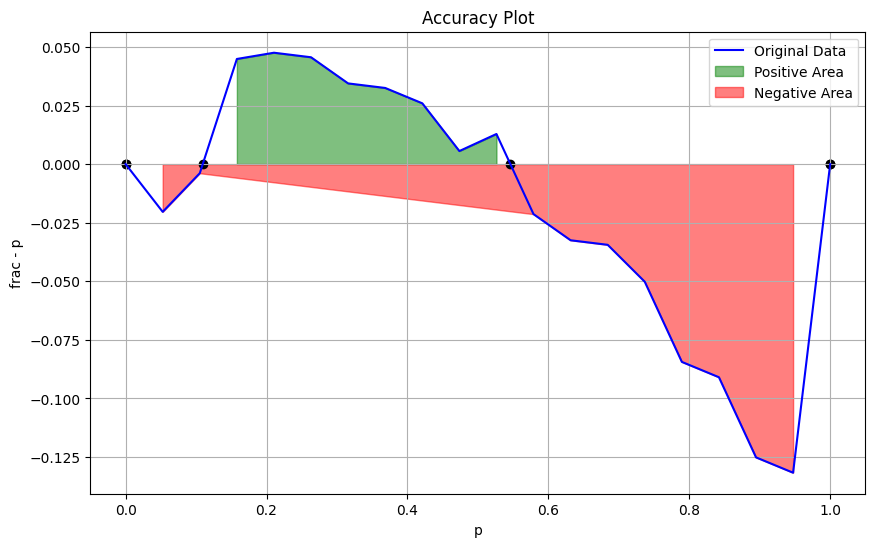

Integral of the positive part: 0.011583500346792282
Integral of the negative part: 0.023789311989651524
=== RESULTS ===
Number of wells in CSV: 217
p_intervals = [0.         0.05263158 0.10526316 0.15789474 0.21052632 0.26315789
 0.31578947 0.36842105 0.42105263 0.47368421 0.52631579 0.57894737
 0.63157895 0.68421053 0.73684211 0.78947368 0.84210526 0.89473684
 0.94736842 1.        ]
fraction_in = [0.         0.03225806 0.10138249 0.20276498 0.25806452 0.30875576
 0.35023041 0.40092166 0.44700461 0.47926267 0.53917051 0.55760369
 0.59907834 0.64976959 0.68663594 0.70506912 0.75115207 0.76958525
 0.8156682  1.        ]
Goodness = 0.9408378756739046


In [38]:
cdf_values = []
for idx, row in uncertainty_results_scaled.iterrows():
    fuel_val = row["Fuel Value"]
    
    # Extract the 100 predictions from columns R1..R100
    preds = row[pred_cols].values  # or row[pred_cols].to_numpy()
    
    mean_ = np.mean(preds)
    std_  = np.std(preds)
    if std_ < 1e-12:
        std_ = 1e-12  # guard against zero std

    # Evaluate the Normal CDF of the well’s Fuel Value
    cdf_ = norm.cdf(fuel_val, loc=mean_, scale=std_)
    cdf_values.append(cdf_)

cdf_values = np.array(cdf_values)
N = len(cdf_values)

# -------------------------------------------------------------------------
# 4) Build fraction_in vs. p for p in [0..1]
# -------------------------------------------------------------------------
p_intervals = np.linspace(0, 1, 20)  # e.g. 20 bins
fraction_in = np.zeros_like(p_intervals)

for i, p in enumerate(p_intervals):
    lower = 0.5 - 0.5 * p
    upper = 0.5 + 0.5 * p
    # fraction of wells whose cdf is in [lower, upper]
    frac = np.mean((cdf_values >= lower) & (cdf_values <= upper))
    fraction_in[i] = frac

# -------------------------------------------------------------------------
# 5) Compute the overall Goodness for the entire dataset
# -------------------------------------------------------------------------
final_goodness = goodness(p_intervals, fraction_in,
                          return_plots=True, return_areas=True)

print("=== RESULTS ===")
print("Number of wells in CSV:", N)
print("p_intervals =", p_intervals)
print("fraction_in =", fraction_in)
print("Goodness =", final_goodness)

As it can be observed, the uncertainty goodness has been increased from ~0.899 to 0.940 for this particular split. The average uncertainty goodness for 50 different splits have been estimated around ~0.91 before the scaling and ~0.935 after the scaling.

In [3]:
# Plotting the histogram of normal vs scaled uncertainty models
# Create the figure and axes
plt.figure(figsize=(10, 6))

# Plot the histograms with enhancements
plt.hist(uncertainty_results.iloc[0][2:], bins=50, alpha=0.6, label='Uncertainty Results', color='blue', edgecolor='black')
plt.hist(uncertainty_results_scaled.iloc[0][2:], bins=50, alpha=0.6, label='Scaled Uncertainty Results', color='orange', edgecolor='black')

# Add titles and labels
plt.title('Comparison of Uncertainty Results', fontsize=16)
plt.xlabel('Value', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Add a legend
plt.legend(fontsize=12)

# Add gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

Now that we finished the model building, training, validation and fine-tuning for uncertainty modeling, we can finally use the entire training dataset (train + validation) and predict the testing dataset, and build the uncertainty model.

In [39]:
# Train on entire dataset.
multi_rf.fit(X, Y)
print("\nFinal model trained on the entire dataset.")


Final model trained on the entire dataset.


### Testing

Naturally, we have to do the same preprocessing and feature engineering on test data to have uniformity between train and test sets.

We start by imputing the temperatures. It is easily observed that some of the well groups with the same padding in the training data miss some wells, which are exactly the wells in testing data. Therefore, using the temperature from these well groups, which are again the same for all wells in a group, is very straightforward.

Then, we use our Estimated Average Stage Time imputing model to impute missing ones in the testing data, and we also create Estimated Total Time feature in the testing dataset.

In [41]:
# Load the testing data
testing_df = pd.read_csv("testing_temperature_imputed.csv")

# Define features used in the trained model
feature_cols = ["Frac Fleet", "Target Formation", "Ambient Temperature", "Fuel Type"]

# Identify rows with missing 'Estimated Average Stage Time'
rows_to_impute = testing_df[testing_df["Estimated Average Stage Time"].isna()]

# Extract features for prediction
X_impute = rows_to_impute[feature_cols]

# Predict missing values using the trained pipeline
imputed_values = pipeline.predict(X_impute)

# Assign the predicted values back to the original DataFrame
testing_df.loc[rows_to_impute.index, "Estimated Average Stage Time"] = imputed_values

testing_df['Estimated Total Time'] = testing_df['Estimated Average Stage Time'] * testing_df['# Stages']

After the preprocessing and feature engineering is completed, we simply predict the testing data.

In [42]:
# Define features used in the trained model
numerical_features = ["Ambient Temperature", "Estimated Total Time"]
categorical_features = ["Fuel Type", "Frac Fleet", "Target Formation"]

# Perform one-hot encoding on testing data
testing_encoded = pd.get_dummies(testing_df, columns=categorical_features, drop_first=False)

# Align testing data to have the same features as the trained model
missing_cols = set(X.columns) - set(testing_encoded.columns)
for col in missing_cols:
    testing_encoded[col] = 0  # Add missing columns with default values

# Reorder columns to match the training dataset
testing_encoded = testing_encoded[X.columns]

# Predict fuel columns using the trained model
fuel_predictions = multi_rf.predict(testing_encoded)

# Add predictions back to the original testing DataFrame
testing_df["Grid_pred"] = fuel_predictions[:, 0]
testing_df["Diesel_pred"] = fuel_predictions[:, 1]
testing_df["CNG_pred"] = fuel_predictions[:, 2]

After we do our prediction, we build our uncertainty model as well.

In [44]:
# Extract individual estimators from the trained multi-output model
grid_estimators = multi_rf.estimators_[0].estimators_
diesel_estimators = multi_rf.estimators_[1].estimators_
cng_estimators = multi_rf.estimators_[2].estimators_

# Initialize lists to store predictions for each fuel type
grid_realizations = []
diesel_realizations = []
cng_realizations = []

# Loop through all estimators to generate predictions for testing data
for est in grid_estimators:
    grid_realizations.append(est.predict(testing_encoded))
for est in diesel_estimators:
    diesel_realizations.append(est.predict(testing_encoded))
for est in cng_estimators:
    cng_realizations.append(est.predict(testing_encoded))

# Convert to arrays for easier column-wise addition
grid_realizations = np.array(grid_realizations).T  # Shape: (n_samples, 100)
diesel_realizations = np.array(diesel_realizations).T
cng_realizations = np.array(cng_realizations).T

# Add realizations as columns to testing_df
for i in range(100):
    testing_df[f"Grid_R{i+1}"] = grid_realizations[:, i]
    testing_df[f"Diesel_R{i+1}"] = diesel_realizations[:, i]
    testing_df[f"CNG_R{i+1}"] = cng_realizations[:, i]

print("Added 100 realizations for each fuel type to testing_df.")

Added 100 realizations for each fuel type to testing_df.


/home/multifrac/defaults/.venv/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/multifrac/defaults/.venv/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/multifrac/defaults/.venv/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/multifrac/defaults/.venv/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/multifrac/defaults/.venv/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/multifrac/defaults/.venv/lib/python3.8/site-

Last, we import the *solution.csv* to fill the result file in the desired format:

In [55]:
# Load solution.csv for reference
solution_reference = pd.read_csv("solution.csv")

# Ensure well names are properly matched
solution_reference.rename(columns={"Masked Well Name": "Well Name"}, inplace=True)

# Initialize lists to store fuel values and realizations
fuel_values = []
realizations = []

# Iterate through each row in solution_reference to match and fill
for _, row in solution_reference.iterrows():
    well_name = row["Well Name"]  # Match well name
    required_fuel_type = row["Fuel Type"]  # Check fuel type required in solution_reference
    testing_row = testing_df.loc[testing_df["Well Name"] == well_name]
    
    if testing_row.empty:
        raise ValueError(f"Well Name '{well_name}' not found in testing_df.")
    
    # Handle DGB cases by checking the required fuel type
    if required_fuel_type in ["DGB_CNG", "Turbine"]:
        selected_fuel = "CNG"
        predictions = testing_row[[f"CNG_R{i+1}" for i in range(100)]].values[0]
    elif required_fuel_type in ["DGB_Diesel", "Diesel"]:
        selected_fuel = "Diesel"
        predictions = testing_row[[f"Diesel_R{i+1}" for i in range(100)]].values[0]
    elif required_fuel_type == "Grid":
        selected_fuel = "Grid"
        predictions = testing_row[[f"Grid_R{i+1}" for i in range(100)]].values[0]
    else:
        raise ValueError(f"Unexpected Fuel Type in solution_reference: {required_fuel_type}")

    # Append the selected fuel value and realizations
    fuel_values.append(selected_fuel)
    realizations.append(predictions)

# Add the realizations back to solution_reference
solution_reference["Fuel Value"] = [realizations[i].mean() for i in range(len(realizations))]

# Add R1 to R100 columns
for i in range(100):
    solution_reference[f"R_{i+1}"] = [realization[i] for realization in realizations]

# Ensure well names are properly matched
solution_reference.rename(columns={"Well Name": "Masked Well Name"}, inplace=True)

scaled_preds_all_wells = []
for well_idx in range(solution_reference.shape[0]):
    original_preds = solution_reference.iloc[well_idx][3:]  # shape (100,)
    new_preds = rescale_predictions(original_preds, scale_factor)
    scaled_preds_all_wells.append(new_preds)

solution_reference_scaled = solution_reference.copy(deep=True)
solution_reference_scaled.iloc[:,3:] = scaled_preds_all_wells

# Save the updated solution_reference
solution_reference_scaled.to_csv("solution.csv", index=False)

## References

1- Breiman, “Random Forests”, Machine Learning, 45(1), 5-32, 2001.

2- Maldonado-Cruz, E., & Pyrcz, M. J. (2021). Tuning machine learning dropout for subsurface uncertainty model accuracy. Journal of Petroleum Science and Engineering, 205, 108975.

3- Ozbayrak, F., Foster, J. T., & Pyrcz, M. J. (2025). Spatial Bagging for Predictive Machine Learning Uncertainty Quantification. Preprint.

4- Deutsch, C. V. (1997). Direct assessment of local accuracy and precision. Geostatistics wollongong, 96(1), 115-125.
